# Linear Support Vector Machine

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

## Class SVM

This is the implementation of the linear SVM:
* There two metods: `train(X, y)` and `y = predict(X)`.
* Matrix `self.W` also includes the bias vector ([bias tricks](https://cs231n.github.io/linear-classify/#interpreting-a-linear-classifier)).
* There are some additoinal parameters for training (hyperparameters).
* Training is done by using stochastic gradient descent method.

In [4]:
class SVM():
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True):
        '''
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        num_train, dim = X.shape
        num_classes = len(np.unique(y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(dim + 1, num_classes) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # evaluate loss and gradient
            loss, grad = svm_loss(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)

        return y_pred

## Breast Cancer Wisconsin

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

[This dataset is also available as one of scikit-learn example datasets](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
).

The original labels are characters: `M` and `B`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `M` is replaced with `1`
* `B` is replaced with `0`

### Load the Dataset

In [5]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,1]=='M')] = 1
y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


### Split The Dataset for Training and Test

In [6]:
X_train = X[0:400, :]
y_train = y[0:400]
X_test  = X[401:, :]
y_test  = y[401:]

num_test = X_test.shape[0]

### Train the Classifier

In [7]:
classifier = SVM()
loss_hist = classifier.train(X_train, y_train, learning_rate=1e-6,batch_size=200, reg=0.1, num_iters=10000)

iteration 0 / 10000: loss 1.075387
iteration 1000 / 10000: loss 0.713064
iteration 2000 / 10000: loss 0.491853
iteration 3000 / 10000: loss 0.422198
iteration 4000 / 10000: loss 0.389567
iteration 5000 / 10000: loss 0.347089
iteration 6000 / 10000: loss 0.441660
iteration 7000 / 10000: loss 0.400906
iteration 8000 / 10000: loss 0.409224
iteration 9000 / 10000: loss 0.393864


### Plot the Loss

Plot the loss as a function of iteration number.

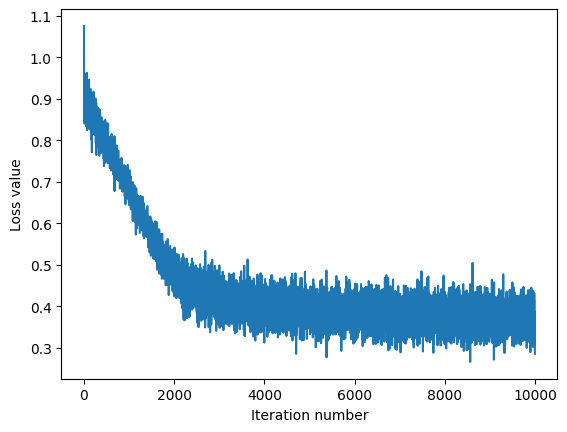

In [8]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier
Evaluate the performance on both the training and validation set.

In [9]:
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.850000
validation accuracy: 0.928571


## Handwritten Digits

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

### Training Data

In [10]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tra", delimiter=",", dtype=int)
X_train = np.int32(data[:, 0:-1])  
y_train = np.int32(data[:, -1]) 

print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(y_train))

Dimension numbers : 64
Number of data    : 3823
Labels            : [0 1 2 3 4 5 6 7 8 9]


### Test Data

In [11]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tes", delimiter=",", dtype=int)
X_test = np.int32(data[:, 0:-1])  
y_test = np.int32(data[:, -1]) 

print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(y_test))

Dimension numbers : 64
Number of data    : 1797
Labels            : [0 1 2 3 4 5 6 7 8 9]


### Train the Classifier

In [12]:
classifier = SVM()
loss_hist = classifier.train(X_train, y_train, learning_rate=1e-5,batch_size=500, num_iters=10000)

iteration 0 / 10000: loss 9.048196


iteration 1000 / 10000: loss 0.547589
iteration 2000 / 10000: loss 0.488439
iteration 3000 / 10000: loss 0.335629
iteration 4000 / 10000: loss 0.294106
iteration 5000 / 10000: loss 0.321944
iteration 6000 / 10000: loss 0.288735
iteration 7000 / 10000: loss 0.212090
iteration 8000 / 10000: loss 0.251241
iteration 9000 / 10000: loss 0.211138


### Plot the Loss

Plot the loss as a function of iteration number.

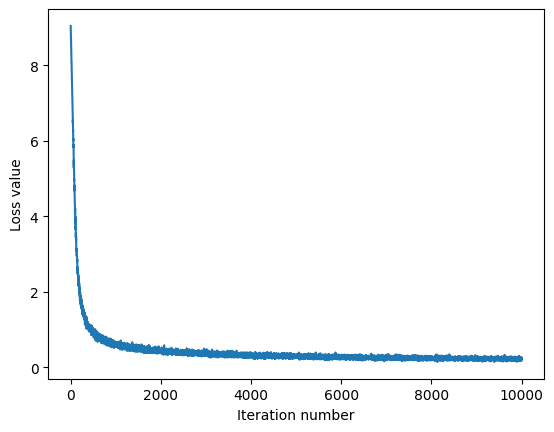

In [13]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier

Evaluate the performance on both the training and validation set.

In [14]:
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.961549
validation accuracy: 0.929327


### Visualize the Learned Weights
* Take matrix `W` and strip out the bias. 
* For each class, reshape the matrix back into 2D arrays
* Plot the 2D arrays (matrices) as images.

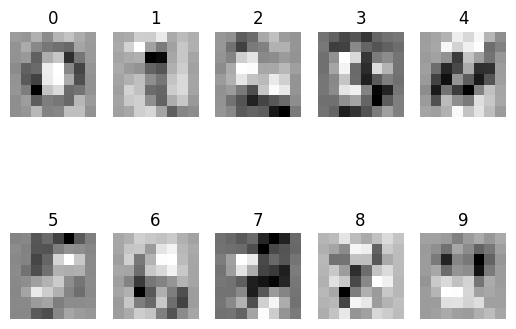

In [15]:
w = classifier.W[:-1, :] # strip out the bias
w = w.reshape(8, 8, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), cmap='Greys')
    plt.axis('off')
    plt.title(classes[i])